In [1]:
import pandas as pd
from pathlib import Path

# 1) Load data
lena_path = Path('/home/engaclew/neurogen/lena_metrics.csv')
aclew_path = Path('/home/engaclew/neurogen/aclew_metrics.csv')
children_path = Path('/home/engaclew/DATA/neurogen/L3_HIPAA_LENA_cleaned/metadata/children.csv')
recordings_path = Path('/home/engaclew/DATA/neurogen/L3_HIPAA_LENA_cleaned/metadata/recordings.csv')
lena_data = pd.read_csv(lena_path)
aclew_data = pd.read_csv(aclew_path)
children = pd.read_csv(children_path)
recordings = pd.read_csv(recordings_path)

# 2) Merge data
recordings_data = recordings.merge(children, on='child_id')
recordings_data = recordings_data[~recordings_data['group_id'].isin(['environmental_risk', 'autism_spectrum_disorder'])][['recording_filename', 'group_id']]
lena_data = lena_data.merge(recordings_data, on='recording_filename')
aclew_data = aclew_data.merge(recordings_data, on='recording_filename')


# 3) Get average voc. dur for kids with Angelman
print("ACLEW")
ANGELMAN_avg_voc_dur_chi = aclew_data.loc[aclew_data['group_id'] == 'angelman_syndrome', 'avg_voc_dur_chi'].mean()
LOW_RISK_avg_voc_dur_chi = aclew_data.loc[aclew_data['group_id'] == 'low_risk', 'avg_voc_dur_chi'].mean()
print(ANGELMAN_avg_voc_dur_chi)
print(LOW_RISK_avg_voc_dur_chi)
print("LENA")
ANGELMAN_avg_voc_dur_chi_lena = lena_data.loc[lena_data['group_id'] == 'angelman_syndrome', 'avg_voc_dur_chi'].mean()
LOW_RISK_avg_voc_dur_chi_lena = lena_data.loc[lena_data['group_id'] == 'low_risk', 'avg_voc_dur_chi'].mean()
print(ANGELMAN_avg_voc_dur_chi_lena)
print(LOW_RISK_avg_voc_dur_chi_lena)

ACLEW
1450.7176744779258
1812.1286713137408
LENA
1010.4738042151401
1115.3086098718638


In [52]:
from ChildProject.projects import ChildProject
from ChildProject.annotations import AnnotationManager
from ChildProject.metrics import segments_to_grid

# Read SEEDLingS annotation
seedlings_path = '/home/engaclew/neurogen/data/bergelson'
seedlings_project = ChildProject(seedlings_path)
seedlings_am = AnnotationManager(seedlings_project)
seedlings_am.read()
intersection = AnnotationManager.intersection(seedlings_am.annotations, ['its', 'eaf/an1', 'vtc'])
recording_ids = list(intersection.loc[intersection['set'] == 'eaf/an1', 'recording_filename'].unique())
recording_ids.remove('123480-1196_7.wav')
recording_ids.remove('123504-1618_1.wav')
recording_ids.remove('123866-7758_1.wav')

In [53]:
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import cohen_kappa_score
import matplotlib.pyplot as plt

def calculate_kappa_by_duration(human_df, lena_df, vtc_df, duration_thresholds, time_step=100):
   results = []
   max_time = max(human_df['segment_offset'].max(), 
                  lena_df['segment_offset'].max(),
                  vtc_df['segment_offset'].max())
   time_points = np.arange(0, max_time, time_step)
   
   def create_human_timeline(all_df, short_df, time_points):
       timeline = np.zeros(len(time_points))  # 0 for true silence
       
       # First mark all vocalizations as -1 (to be excluded)
       for _, row in all_df.iterrows():
           start_idx = np.searchsorted(time_points, row['segment_onset'])
           end_idx = np.searchsorted(time_points, row['segment_offset'])
           timeline[start_idx:end_idx] = -1
       
       # Then mark short vocalizations as 1
       for _, row in short_df.iterrows():
           start_idx = np.searchsorted(time_points, row['segment_onset'])
           end_idx = np.searchsorted(time_points, row['segment_offset'])
           timeline[start_idx:end_idx] = 1
           
       return timeline
   
   def create_system_timeline(df, time_points):
       timeline = np.zeros(len(time_points))  # 0 for silence
       for _, row in df.iterrows():
           start_idx = np.searchsorted(time_points, row['segment_onset'])
           end_idx = np.searchsorted(time_points, row['segment_offset'])
           timeline[start_idx:end_idx] = 1
       return timeline
   
   for threshold in duration_thresholds:
        # Get short human segments
        human_short = human_df[human_df['segment_duration'] <= threshold]
        
        # Create timelines
        human_timeline = create_human_timeline(human_df, human_short, time_points)
        lena_timeline = create_system_timeline(lena_df, time_points)
        vtc_timeline = create_system_timeline(vtc_df, time_points)
        
        # Only consider points where human timeline is not -1
        valid_points = human_timeline != -1
        
        if valid_points.any():
            vtc_human_kappa = cohen_kappa_score(
                human_timeline[valid_points],
                vtc_timeline[valid_points]
            )
            lena_human_kappa = cohen_kappa_score(
                human_timeline[valid_points],
                lena_timeline[valid_points]
            )
            lena_vtc_kappa = cohen_kappa_score(
                lena_timeline[valid_points],
                vtc_timeline[valid_points]
            )
        else:
            vtc_human_kappa = lena_human_kappa = lena_vtc_kappa = np.nan
            
        # Calculate average duration only for human short vocalizations
        human_avg_dur = human_short['segment_duration'].mean() if len(human_short) > 0 else np.nan
            
        results.append({
            'threshold': threshold,
            'vtc_human_kappa': vtc_human_kappa,
            'lena_human_kappa': lena_human_kappa,
            'lena_vtc_kappa': lena_vtc_kappa,
            'n_human_short': len(human_short),
            'prop_valid_points': valid_points.mean(),
            'human_avg_dur': human_avg_dur
        })
    
   return pd.DataFrame(results)

thresholds = np.arange(250, 5001, 250)
# Initialize dictionary to store results
all_results = {threshold: [] for threshold in thresholds}

# Process each recording
for recording_id in tqdm(recording_ids):
    recording_intersection = intersection[intersection['recording_filename'] == recording_id]
    segments = seedlings_am.get_collapsed_segments(recording_intersection)
    segments = segments[segments['speaker_type'] == 'CHI']
    segments['segment_duration'] = segments['segment_offset'] - segments['segment_onset']
    
    vtc_segments = segments[segments['set'] == 'vtc']
    lena_segments = segments[segments['set'] == 'its']
    human_segments = segments[segments['set'] == 'eaf/an1']
    
    results_df = calculate_kappa_by_duration(human_segments, lena_segments, vtc_segments, thresholds)
    # Store results for each threshold
    for _, row in results_df.iterrows():
        all_results[row['threshold']].append(row)

# Calculate aggregate statistics
aggregate_results = []
for threshold in thresholds:
    results = all_results[threshold]
    
    aggregate_results.append({
        'threshold': threshold,
        'vtc_human_kappa_mean': np.mean([r['vtc_human_kappa'] for r in results if not np.isnan(r['vtc_human_kappa'])]),
        'vtc_human_kappa_std': np.std([r['vtc_human_kappa'] for r in results if not np.isnan(r['vtc_human_kappa'])]),
        'lena_human_kappa_mean': np.mean([r['lena_human_kappa'] for r in results if not np.isnan(r['lena_human_kappa'])]),
        'lena_human_kappa_std': np.std([r['lena_human_kappa'] for r in results if not np.isnan(r['lena_human_kappa'])]),
        'lena_vtc_kappa_mean': np.mean([r['lena_vtc_kappa'] for r in results if not np.isnan(r['lena_vtc_kappa'])]),
        'lena_vtc_kappa_std': np.std([r['lena_vtc_kappa'] for r in results if not np.isnan(r['lena_vtc_kappa'])]),
        'n_files': len(results),
        'prop_valid_mean': np.mean([r['prop_valid_points'] for r in results]),
        'human_avg_dur_mean': np.mean([r['human_avg_dur'] for r in results if not np.isnan(r['human_avg_dur'])]),
        'human_avg_dur_std': np.std([r['human_avg_dur'] for r in results if not np.isnan(r['human_avg_dur'])])
    })

aggregate_df = pd.DataFrame(aggregate_results)

  0%|                                                    | 0/10 [00:00<?, ?it/s]/home/engaclew/miniconda3/envs/neurogen/lib/python3.10/site-packages/ChildProject/annotations.py:1519: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  annotations["duration"] = (
 10%|████▍                                       | 1/10 [00:02<00:20,  2.28s/it]/home/engaclew/miniconda3/envs/neurogen/lib/python3.10/site-packages/ChildProject/annotations.py:1519: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  annotations["duration"] = 

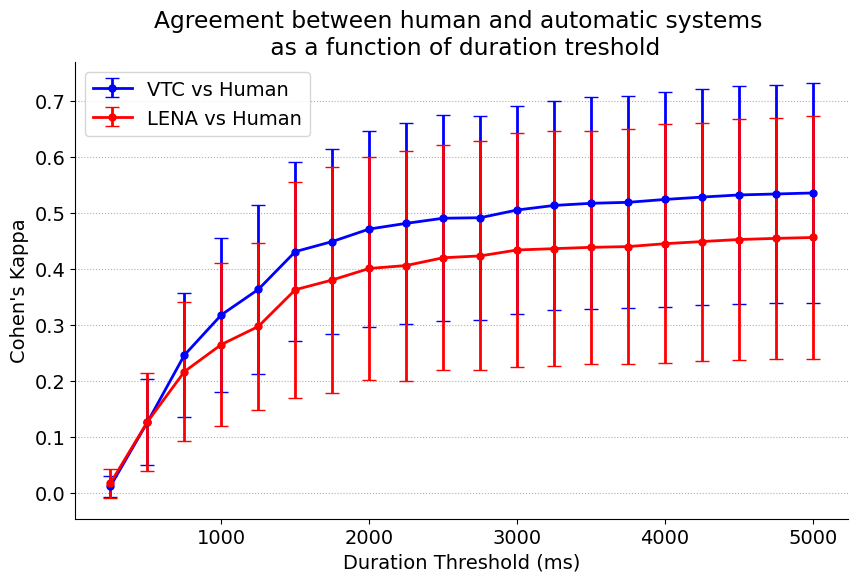

In [56]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import gridspec

matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.serif'] = 'Arial'
matplotlib.rcParams.update({'font.size': 14, 'legend.handleheight':1, 'hatch.linewidth': 1.0,
                           'lines.markersize':5, 'lines.linewidth':2, 'errorbar.capsize': 5})

cm = 1/2.54
fig = plt.figure(figsize=(21.5*cm,14.5*cm), constrained_layout=True)
gs = gridspec.GridSpec(1, 4, figure=fig, height_ratios=[1])
ax = fig.add_subplot(gs[0, :])

ax.errorbar(aggregate_df['threshold'], aggregate_df['vtc_human_kappa_mean'], 
            yerr=aggregate_df['vtc_human_kappa_std'], fmt='b-o', label='VTC vs Human')
ax.errorbar(aggregate_df['threshold'], aggregate_df['lena_human_kappa_mean'], 
            yerr=aggregate_df['lena_human_kappa_std'], fmt='r-o', label='LENA vs Human')
ax.set_xlabel('Duration Threshold (ms)')
ax.set_ylabel("Cohen's Kappa")
ax.set_title("Agreement between human and automatic systems \n as a function of duration treshold")
ax.grid(visible=True, axis='y', linestyle=':', zorder=0)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.legend()
ymin, ymax = ax.get_ylim()
plt.savefig('/home/engaclew/neurogen/results/duration_treshold/human_vs_automatic.png', dpi=300)
plt.show()

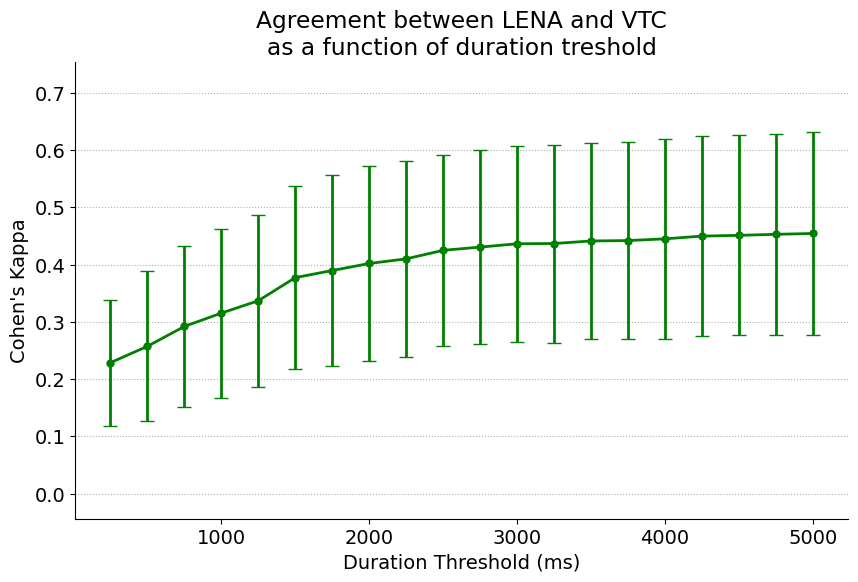

In [22]:
from scipy.interpolate import interp1d

cm = 1/2.54
fig = plt.figure(figsize=(21.5*cm,14.5*cm), constrained_layout=True)
gs = gridspec.GridSpec(1, 4, figure=fig, height_ratios=[1])
ax = fig.add_subplot(gs[0, :])

ax.errorbar(aggregate_df['threshold'], aggregate_df['lena_vtc_kappa_mean'], 
            yerr=aggregate_df['lena_vtc_kappa_std'], fmt='g-o', label='LENA vs VTC')
ax.set_xlabel('Duration Threshold (ms)')
ax.set_ylabel("Cohen's Kappa")
ax.set_title("Agreement between LENA and VTC\nas a function of duration treshold")
ax.grid(visible=True, axis='y', linestyle=':', zorder=0)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylim(ymin, ymax)



plt.savefig('/home/engaclew/neurogen/results/duration_treshold/LENA_vs_VTC.png', dpi=300)
plt.show()

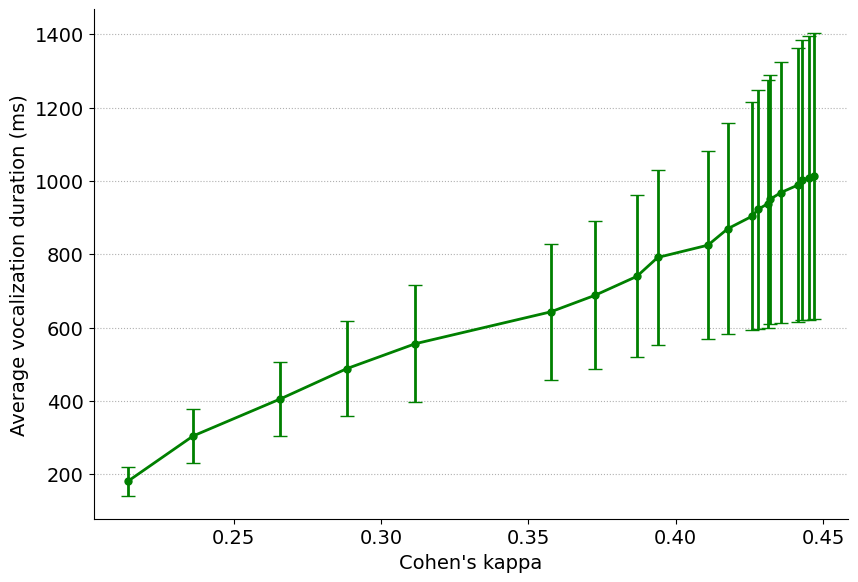

In [71]:
cm = 1/2.54
fig = plt.figure(figsize=(21.5*cm,14.5*cm), constrained_layout=True)
gs = gridspec.GridSpec(1, 4, figure=fig, height_ratios=[1])
ax = fig.add_subplot(gs[0, :])

ax.errorbar(aggregate_df['lena_vtc_kappa_mean'], aggregate_df['human_avg_dur_mean'], yerr=aggregate_df['human_avg_dur_std'], fmt='g-o')
ax.set_xlabel("Cohen's kappa")
ax.set_ylabel("Average vocalization duration (ms)")
ax.grid(visible=True, axis='y', linestyle=':', zorder=0)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)



plt.savefig('/home/engaclew/neurogen/results/duration_treshold/Average_voc_dur_as_kappa.png', dpi=300)
plt.show()

1450.7176744779258

1450.7176744779258
1812.1286713137408


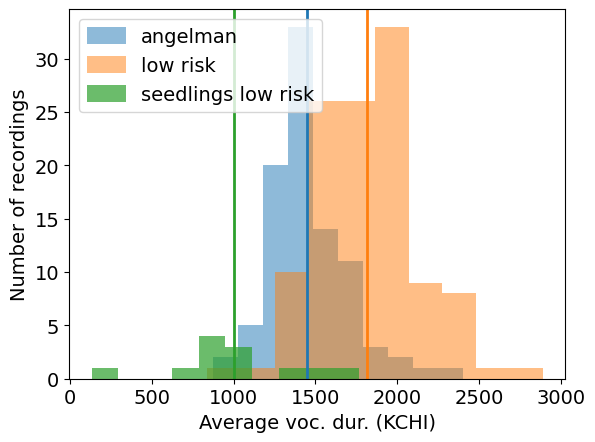

In [74]:
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

plt.hist(aclew_data.loc[aclew_data['group_id'] == 'angelman_syndrome', 'avg_voc_dur_chi'], alpha=.5, label='angelman', color=colors[0])
plt.axvline(aclew_data.loc[aclew_data['group_id'] == 'angelman_syndrome', 'avg_voc_dur_chi'].mean(), color=colors[0])
print(aclew_data.loc[aclew_data['group_id'] == 'angelman_syndrome', 'avg_voc_dur_chi'].mean())

plt.hist(aclew_data.loc[aclew_data['group_id'] == 'low_risk', 'avg_voc_dur_chi'], alpha=.5, label='low risk', color=colors[1])
plt.axvline(aclew_data.loc[aclew_data['group_id'] == 'low_risk', 'avg_voc_dur_chi'].mean(), color=colors[1])
print(aclew_data.loc[aclew_data['group_id'] == 'low_risk', 'avg_voc_dur_chi'].mean())

segments = seedlings_am.get_collapsed_segments(intersection)
segments = segments[segments['speaker_type'] == 'CHI']
segments = segments[segments['set'] == 'eaf/an1']
segments['duration'] = segments['segment_offset'] - segments['segment_onset']
plt.hist(segments.groupby('recording_filename')['duration'].mean(), alpha=.7, label='seedlings low risk', color=colors[2])
plt.axvline(segments.groupby('recording_filename')['duration'].mean().mean(), color=colors[2])

plt.ylabel('Number of recordings')
plt.xlabel('Average voc. dur. (KCHI)')
plt.legend()
plt.savefig('/home/engaclew/neurogen/results/duration_treshold/average_voc_dur.png', dpi=300)

In [75]:
segments.columns[

Index(['segment_onset', 'segment_offset', 'speaker_id', 'speaker_type',
       'vcm_type', 'lex_type', 'mwu_type', 'addressee', 'transcription',
       'words', 'raw_filename', 'set', 'recording_filename', 'time_seek',
       'range_onset', 'range_offset', 'format', 'filter',
       'annotation_filename', 'imported_at', 'package_version', 'error',
       'merged_from', 'duration', 'position', 'lena_speaker',
       'lena_block_number', 'lena_block_type', 'lena_conv_status',
       'lena_response_count', 'lena_conv_turn_type', 'lena_conv_floor_type',
       'utterances_count', 'utterances_length', 'average_db', 'peak_db',
       'utterances', 'non_speech_length', 'child_cry_vfx_len', 'cries',
       'vfxs'],
      dtype='object')

recording_filename
123439-0396_1.wav     932.006098
123480-1196_4.wav     819.454545
123480-1196_6.wav     845.792929
123480-1196_8.wav     132.000000
123504-1618_1.wav     795.708333
123517-1844_1.wav    1765.901408
123579-2927_1.wav     969.737705
123614-3749_1.wav    1540.297297
123620-3895_1.wav    1049.274390
123727-5750_1.wav    1430.258065
123743-6035_1.wav    1024.189474
123866-7758_1.wav     695.564815
Name: duration, dtype: float64